# Create 7777 video - 'everyday' alignment 2nd attempt

This notebook shows the full code base needed to align all of Noah's images from the 'everyday' project and create the video [7777](https://www.youtube.com/watch?v=DC1KHAxE7mo).

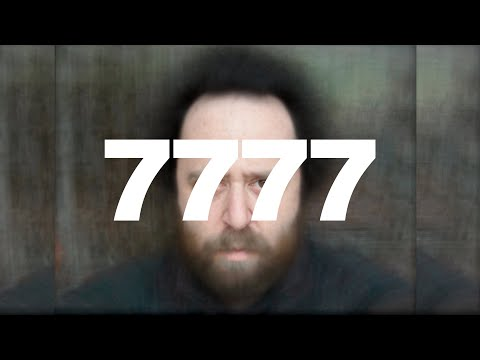

In [1]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('DC1KHAxE7mo')

In short, we use [dlib](http://dlib.net/) toolbox to detect, extract and align faces from all the images. The process to do so is a 2-step process:

1. We use `hog_detector` detector to find the faces in all images. This detector is 'ok-ish' but runs very quickly.
2. For all images where it wasn't possible to detect a face, we use the `cnn_face_detection_model_v1` routine. This routine is slower but more accurate.

Dlib's face detection is usually used to extract small 'chips'/patches of pixels that only contain the face. In this case however we decided to keep the full image, but just profit from dlib's routine of aligning the faces according to the 5 landmarks (two eyes, nose and two corners of the mouth). During this procedure, images are also upscaled to 4k (3840, 2160) resolution.

# Prepare everything

In [1]:
import os
import shutil
import cv2
from skimage import io
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches

from tqdm.notebook import tqdm

In [2]:
# Collect all file names
filenames = sorted(glob('img_orig/*'))
filenames[:5] + filenames[-5:]

['img_orig/20000110.jpg',
 'img_orig/20000111.jpg',
 'img_orig/20000112.jpg',
 'img_orig/20000113.jpg',
 'img_orig/20000115.jpg',
 'img_orig/20210608.JPG',
 'img_orig/20210609.JPG',
 'img_orig/20210610.JPG',
 'img_orig/20210611.JPG',
 'img_orig/20210612.JPG']

In [3]:
len(filenames)

7777

# Correct and align images with `skimage` and `dlib`

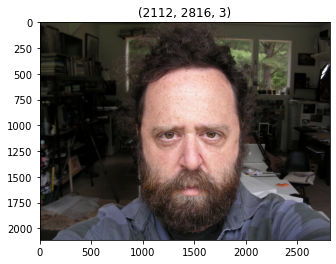

In [4]:
# Show last image in the dataset
last_img = io.imread(filenames[-1])
plt.title(last_img.shape)
plt.imshow(last_img);

In [5]:
# Create output folder for aligned images
out_dir = 'img_aligned'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [6]:
import dlib

# Additional dlib models for face recognition
shape_predictor = dlib.shape_predictor('dlib/shape_predictor_5_face_landmarks.dat') # Faces landmarks (points)

# Which face detector to use
hog_detector = dlib.get_frontal_face_detector()
cnn_detector = dlib.cnn_face_detection_model_v1('dlib/mmod_human_face_detector.dat')

In [7]:
face_chip_size = (1920, 1080) # full hd
face_chip_size = (3840, 2160) # 4k

In [8]:
def crop_img(img, dim=(1920, 1080), ratio=7.):
    offset = int(dim[0]/ratio)
    return img[offset:offset+dim[1], ...]

### Go through with hog_detector

In [9]:
# CNN is more advanced but takes longer; hog misses ~100 faces in total
face_detector = hog_detector

In [10]:
align_files = False

In [11]:
from skimage.exposure import rescale_intensity

padding = np.divide(*face_chip_size)

issues = []

if align_files:

    for f in tqdm(filenames):

        # Specify new filename
        new_filename = os.path.join('img_aligned', os.path.basename(f))
        if os.path.exists(new_filename):
            continue

        # Load image
        im = io.imread(f)

        # Get information about image size
        w, h = im.shape[:2]
        offset = (h - w)//2

        """
        # Correct image intensity
        plow, phigh = np.percentile(im, (0, 99))
        im_corrected = rescale_intensity(im, in_range=(plow, phigh))
        """

        # Center image in a canvas
        canvas = np.zeros((h, h, 3)).astype('uint8')
        canvas[offset:-offset, ...] = im

        # Detect faces and align image
        rectangles = [x if isinstance(x, dlib.rectangle) else x.rect for x in face_detector(canvas, 1)]
        if len(rectangles):
            landmarks = [shape_predictor(canvas, r) for r in rectangles]
            face_chips = [dlib.get_face_chip(canvas, l, size=face_chip_size[0],
                                             padding=padding) for l in landmarks]

            # Crop image to write ratio
            img_final = crop_img(face_chips[0], dim=face_chip_size, ratio=7)

            # Save aligned image
            io.imsave(new_filename, img_final)

        else:
            print('new issue found:', f)
            issues.append(f)

In [12]:
print(len(issues))
issues

0


[]

### Go through issue images with cnn_detector

In [13]:
# CNN is more advanced but takes longer; hog misses ~100 faces in total
face_detector = cnn_detector

In [14]:
from skimage.exposure import rescale_intensity

padding = np.divide(*face_chip_size)

issues_still = []

for f in tqdm(issues):
    
    # Load image
    im = io.imread(f)
    
    # Get information about image size
    w, h = im.shape[:2]
    offset = (h - w)//2
    
    """
    # Correct image intensity
    plow, phigh = np.percentile(im, (0, 99))
    im_corrected = rescale_intensity(im, in_range=(plow, phigh))
    """

    # Center image in a canvas
    canvas = np.zeros((h, h, 3)).astype('uint8')
    canvas[offset:-offset, ...] = im

    # Detect faces and align image
    rectangles = [x if isinstance(x, dlib.rectangle) else x.rect for x in face_detector(canvas, 1)]
    if len(rectangles):
        landmarks = [shape_predictor(canvas, r) for r in rectangles]
        face_chips = [dlib.get_face_chip(canvas, l, size=face_chip_size[0],
                                         padding=padding) for l in landmarks]
        
        # Crop image to write ratio
        img_final = crop_img(face_chips[0], dim=face_chip_size, ratio=7)

        # Save aligned image
        io.imsave(os.path.join('img_aligned', os.path.basename(f)), img_final)
        
    else:
        print('new issue found:', f)
        issues_still.append(f)

0it [00:00, ?it/s]

In [15]:
print(len(issues_still))
issues_still

0


[]

In [16]:
# Number of images
print(len(filenames), len(glob('img_aligned/20*')))

7777 7777


# Setup video parameters

In [17]:
# Get all filenames
imgs = sorted(glob('img_aligned/20*'))

# Extract number of images
N_total = len(imgs)
N_total

7777

In [18]:
# How many images to smooth at once
smooth = 60

In [19]:
# How many days to jump at every image
step_size = 1

In [20]:
# Get start indeces for images
ids = [i*step_size for i in range((N_total+smooth)//step_size+1)]
len(ids)

7838

In [21]:
# Specify frames per second
fps = 30

print('Video length: %.2f seconds.' % (len(ids)/fps))

Video length: 261.27 seconds.


# Create averages, medians, etc. images

### Mean image

In [ ]:
# Save images to disk
out_dir = 'img_video_%ddays_mean' % (smooth)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# To keep track what was already loaded
already_loaded = []

for i in tqdm(ids):
    
    # Collect indeces of images
    imgs_idx = np.arange(np.clip(i-smooth, 0, N_total-1), np.clip(i, 0, N_total-1)+1)

    # Collect images relevant for the group
    group_names = np.array(imgs)[imgs_idx]
    
    # Detect which one is new to load
    new_to_load = np.setdiff1d(group_names, already_loaded)
    
    if len(new_to_load)==0:
        pass
    elif i==0:
        imgs_group = np.array([io.imread(f) for f in new_to_load])
    else:
        img_new = np.array([io.imread(f) for f in new_to_load])
        imgs_group = np.vstack((imgs_group, img_new))
        
    # Cut imgs_group to write size
    n_offset = (i - N_total)
    if n_offset <= 0:
        n_offset = 0
    elif n_offset%2==0:
        n_offset -= 1
    imgs_group = imgs_group[-smooth+n_offset:]
    
    # Create composition image
    img_comp = np.mean(imgs_group, axis=0).astype('int')
    
    # Create out_filename
    out_filename = os.path.join(out_dir, '%04d.jpg' % (i + 1))
    
    # Save composition image
    io.imsave(out_filename, img_comp.astype('uint8'))

    # Keep track of what has already been loaded
    already_loaded = group_names

In [ ]:
# Use either code (the one that works) to create the video
!cat img_video_60days_mean/*jpg | ffmpeg -f image2pipe -r $fps -vcodec mjpeg -i - -vcodec libx264 video_60days_mean.mp4
!ffmpeg -r 30 -f image2 -pattern_type glob -i 'img_video_60days_mean/*.jpg' -c:v libx264 -profile:v high video_60days_mean.mp4